In [1]:
#Importing Packages
import numpy as np
import xarray as xr
from tinygp import kernels, GaussianProcess
import jax
from jax import random
import jax.numpy as jnp
import numpyro.distributions as dist
import matplotlib.pyplot as plt
import arviz as az
from src.model_fitting_functions import run_inference
from src.examples_functions import create_levels,hierarchical_model,truth_posterior_predictive,bias_posterior_predictive
from src.examples_functions import posterior_predictive_realisations_hierarchical_mean, posterior_predictive_realisations_hierarchical_var

plt.rcParams['lines.markersize'] = 3
plt.rcParams['lines.linewidth'] = 0.4

rng_key = random.PRNGKey(5)
rng_key, rng_key_ = random.split(rng_key)
jax.config.update("jax_enable_x64", True)

In [2]:
#Creating Underlying Process Data 

X1 = np.arange(0,105,2)
X2 = np.arange(0,105,2)
D = np.arange(0,100,1)

ds = xr.Dataset(
    coords=dict(
        X1=("X1", X1),
        X2=("X2", X2),
        D=("D", D),
    ),
)

ds_stacked = ds.stack(X=('X1', 'X2'))
X = np.array(list(map(np.array, ds_stacked.X.data)))

In [3]:
#Latent mean and variance for truth and bias processes
GP_T_MEAN = GaussianProcess(1 * kernels.ExpSquared(10),X,diag=1e-5,mean=1.0)
GP_T_LOGVAR = GaussianProcess(1 * kernels.ExpSquared(10),X,diag=1e-5,mean=-1.0)
GP_B_MEAN = GaussianProcess(1 * kernels.ExpSquared(40),X,diag=1e-5,mean=-1.0)
GP_B_LOGVAR = GaussianProcess(1 * kernels.ExpSquared(40),X,diag=1e-5,mean=-1.0)

MEAN_T = GP_T_MEAN.sample(rng_key)
rng_key, rng_key_ = random.split(rng_key)
LOGVAR_T = GP_T_LOGVAR.sample(rng_key)
rng_key, rng_key_ = random.split(rng_key)
MEAN_B = GP_B_MEAN.sample(rng_key)
rng_key, rng_key_ = random.split(rng_key)
LOGVAR_B = GP_B_LOGVAR.sample(rng_key)
MEAN_C = MEAN_T + MEAN_B
LOGVAR_C = LOGVAR_T + LOGVAR_B

ds_stacked["MEAN_T"]=(['X'],  MEAN_T)
ds_stacked["LOGVAR_T"]=(['X'],  LOGVAR_T)
ds_stacked["VAR_T"]=(['X'],  jnp.exp(LOGVAR_T))
ds_stacked["MEAN_B"]=(['X'],  MEAN_B)
ds_stacked["LOGVAR_B"]=(['X'],  LOGVAR_B)
ds_stacked["VAR_B"]=(['X'],  jnp.exp(LOGVAR_B))
ds_stacked["MEAN_C"]=(['X'],  MEAN_C)
ds_stacked["LOGVAR_C"]=(['X'],  LOGVAR_C)
ds_stacked["VAR_C"]=(['X'],  jnp.exp(LOGVAR_C))
ds = ds_stacked.unstack()

In [4]:
Normal_T = dist.Normal(ds.MEAN_T.data, jnp.sqrt(ds.VAR_T.data))
T = Normal_T.sample(rng_key,ds.D.shape)

Normal_C = dist.Normal(ds.MEAN_C.data, jnp.sqrt(ds.VAR_C.data))
C = Normal_C.sample(rng_key,ds.D.shape)

ds["T"]=(['D','X1','X2'],  T)
ds["C"]=(['D','X1','X2'],  C)

In [5]:
#Checking for Nans
ds.isnull().sum()

<xarray.Dataset>
Dimensions:   ()
Data variables:
    MEAN_T    int64 0
    LOGVAR_T  int64 0
    VAR_T     int64 0
    MEAN_B    int64 0
    LOGVAR_B  int64 0
    VAR_B     int64 0
    MEAN_C    int64 0
    LOGVAR_C  int64 0
    VAR_C     int64 0
    T         int64 0
    C         int64 0

In [6]:
#Observations
da_obs = ds.T.isel(X1=slice(1,None,5),X2=slice(1,None,5))
X1_condition = (ds.X1<25) | (ds.X1>75) 
X2_condition = (ds.X2<25) | (ds.X2>75) 
da_obs = da_obs.where(X1_condition|X2_condition,drop=True)
da_obs_stacked = da_obs.stack(X=('X1', 'X2'))

#Climate model
da_climate = ds.C.isel(X1=slice(None,None,5),X2=slice(None,None,5))
da_climate_stacked = da_climate.stack(X=('X1', 'X2'))

In [7]:
da_obs.isnull().sum()

<xarray.DataArray 'T' ()>
array(2500)

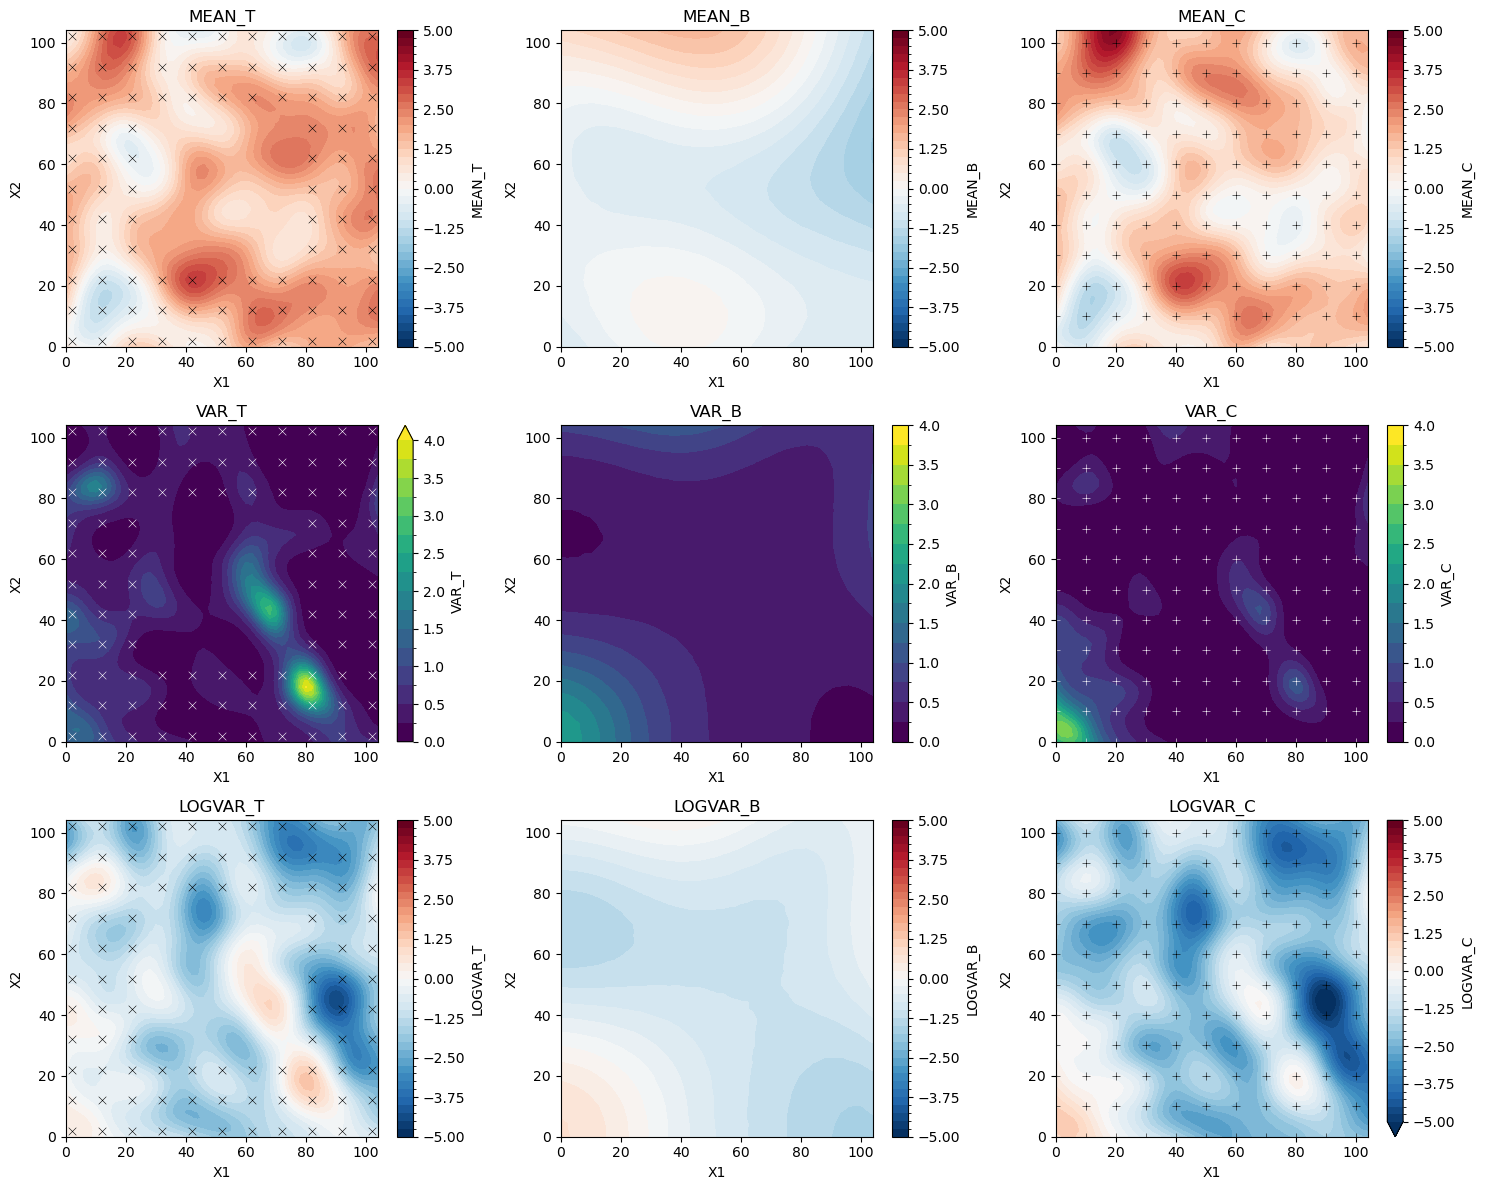

In [8]:
fig, axs = plt.subplots(3, 3, figsize=(15, 12))
plots = []
variables = ['MEAN_T','MEAN_B','MEAN_C','VAR_T','VAR_B','VAR_C','LOGVAR_T','LOGVAR_B','LOGVAR_C']
mean_levels = create_levels(ds[['MEAN_T','MEAN_B','MEAN_C']],0.25,0,center=True)
var_levels = create_levels(ds[['VAR_T','VAR_B','VAR_C']],0.25,0)
logvar_levels = create_levels(ds[['LOGVAR_T','LOGVAR_B','LOGVAR_C']],0.25,0,center=True)

for i in np.arange(0,3,1):
    plt.subplot(3, 3, i+1)
    plots.append(
        ds[f'{variables[i]}'].plot.contourf(x='X1',y='X2',levels=mean_levels)
    )
    plt.title(variables[i])

for i in np.arange(3,6,1):
    plt.subplot(3, 3, i+1)
    plots.append(
        ds[f'{variables[i]}'].plot.contourf(x='X1',y='X2',levels=var_levels)
    )
    plt.title(variables[i])

for i in np.arange(6,9,1):
    plt.subplot(3, 3, i+1)
    plots.append(
        ds[f'{variables[i]}'].plot.contourf(x='X1',y='X2',levels=logvar_levels)
    )
    plt.title(variables[i])

axs[0,0].scatter(da_obs_stacked.dropna('X').X1, da_obs_stacked.dropna('X').X2, s=30, marker='x', c='k')
axs[1,0].scatter(da_obs_stacked.dropna('X').X1, da_obs_stacked.dropna('X').X2, s=30, marker='x', c='w')
axs[2,0].scatter(da_obs_stacked.dropna('X').X1, da_obs_stacked.dropna('X').X2, s=30, marker='x', c='k')
axs[0,2].scatter(da_climate_stacked.X1, da_climate_stacked.X2, s=30, marker='+', c='k')
axs[1,2].scatter(da_climate_stacked.X1, da_climate_stacked.X2, s=30, marker='+', c='w')
axs[2,2].scatter(da_climate_stacked.X1, da_climate_stacked.X2, s=30, marker='+', c='k')

plt.tight_layout()

In [9]:
ox = np.array(list(map(np.array, da_obs_stacked.dropna('X').X.data)))
cx = np.array(list(map(np.array, da_climate_stacked.X.data)))
odata = da_obs_stacked.dropna('X').data
cdata = da_climate_stacked.data

In [10]:
print(cdata.shape,odata.shape,cx.shape,ox.shape)

(100, 121) (100, 96) (121, 2) (96, 2)


In [11]:
#Loading Output from MCMC
outfile_dir = '/home/jez/Bias_Correction/data/Examples_Output/'
idata_hierarchical = az.from_netcdf(f'{outfile_dir}idata_hierarchical.nc')

In [12]:
#Realisations
ds_predictions = ds.isel(X1=slice(None,None,2),X2=slice(None,None,2))
ds_predictions_stacked = ds_predictions.stack(X=('X1', 'X2'))
nx = np.array(list(map(np.array, ds_predictions_stacked.X.data)))

num_parameter_realisations = 20
num_posterior_pred_realisations = 20

truth_realisations_mean = posterior_predictive_realisations_hierarchical_mean(truth_posterior_predictive,nx,ox,cx,idata_hierarchical,num_parameter_realisations,num_posterior_pred_realisations)
bias_realisations_mean = posterior_predictive_realisations_hierarchical_mean(bias_posterior_predictive,nx,ox,cx,idata_hierarchical,num_parameter_realisations,num_posterior_pred_realisations)

truth_realisations_logvar = posterior_predictive_realisations_hierarchical_var(truth_posterior_predictive,nx,ox,cx,idata_hierarchical,num_parameter_realisations,num_posterior_pred_realisations)
bias_realisations_logvar = posterior_predictive_realisations_hierarchical_var(bias_posterior_predictive,nx,ox,cx,idata_hierarchical,num_parameter_realisations,num_posterior_pred_realisations)
truth_realisations_var = np.exp(truth_realisations_logvar)
bias_realisations_var = np.exp(bias_realisations_logvar)

ds_predictions_stacked["mt_mean"]=(['X'],  truth_realisations_mean.mean(axis=(0,1)))
ds_predictions_stacked["mt_std"]=(['X'],  truth_realisations_mean.std(axis=(0,1)))
ds_predictions_stacked["mb_mean"]=(['X'],  bias_realisations_mean.mean(axis=(0,1)))
ds_predictions_stacked["mb_std"]=(['X'],  bias_realisations_mean.std(axis=(0,1)))

ds_predictions_stacked["vt_mean"]=(['X'],  truth_realisations_var.mean(axis=(0,1)))
ds_predictions_stacked["vt_std"]=(['X'],  truth_realisations_var.std(axis=(0,1)))
ds_predictions_stacked["vb_mean"]=(['X'],  bias_realisations_var.mean(axis=(0,1)))
ds_predictions_stacked["vb_std"]=(['X'],  bias_realisations_var.std(axis=(0,1)))

ds_predictions_stacked["lvt_mean"]=(['X'],  truth_realisations_logvar.mean(axis=(0,1)))
ds_predictions_stacked["lvt_std"]=(['X'],  truth_realisations_logvar.std(axis=(0,1)))
ds_predictions_stacked["lvb_mean"]=(['X'],  bias_realisations_logvar.mean(axis=(0,1)))
ds_predictions_stacked["lvb_std"]=(['X'],  bias_realisations_logvar.std(axis=(0,1)))

ds_predictions = ds_predictions_stacked.unstack()

100%|██████████| 20/20 [00:05<00:00,  3.42it/s]


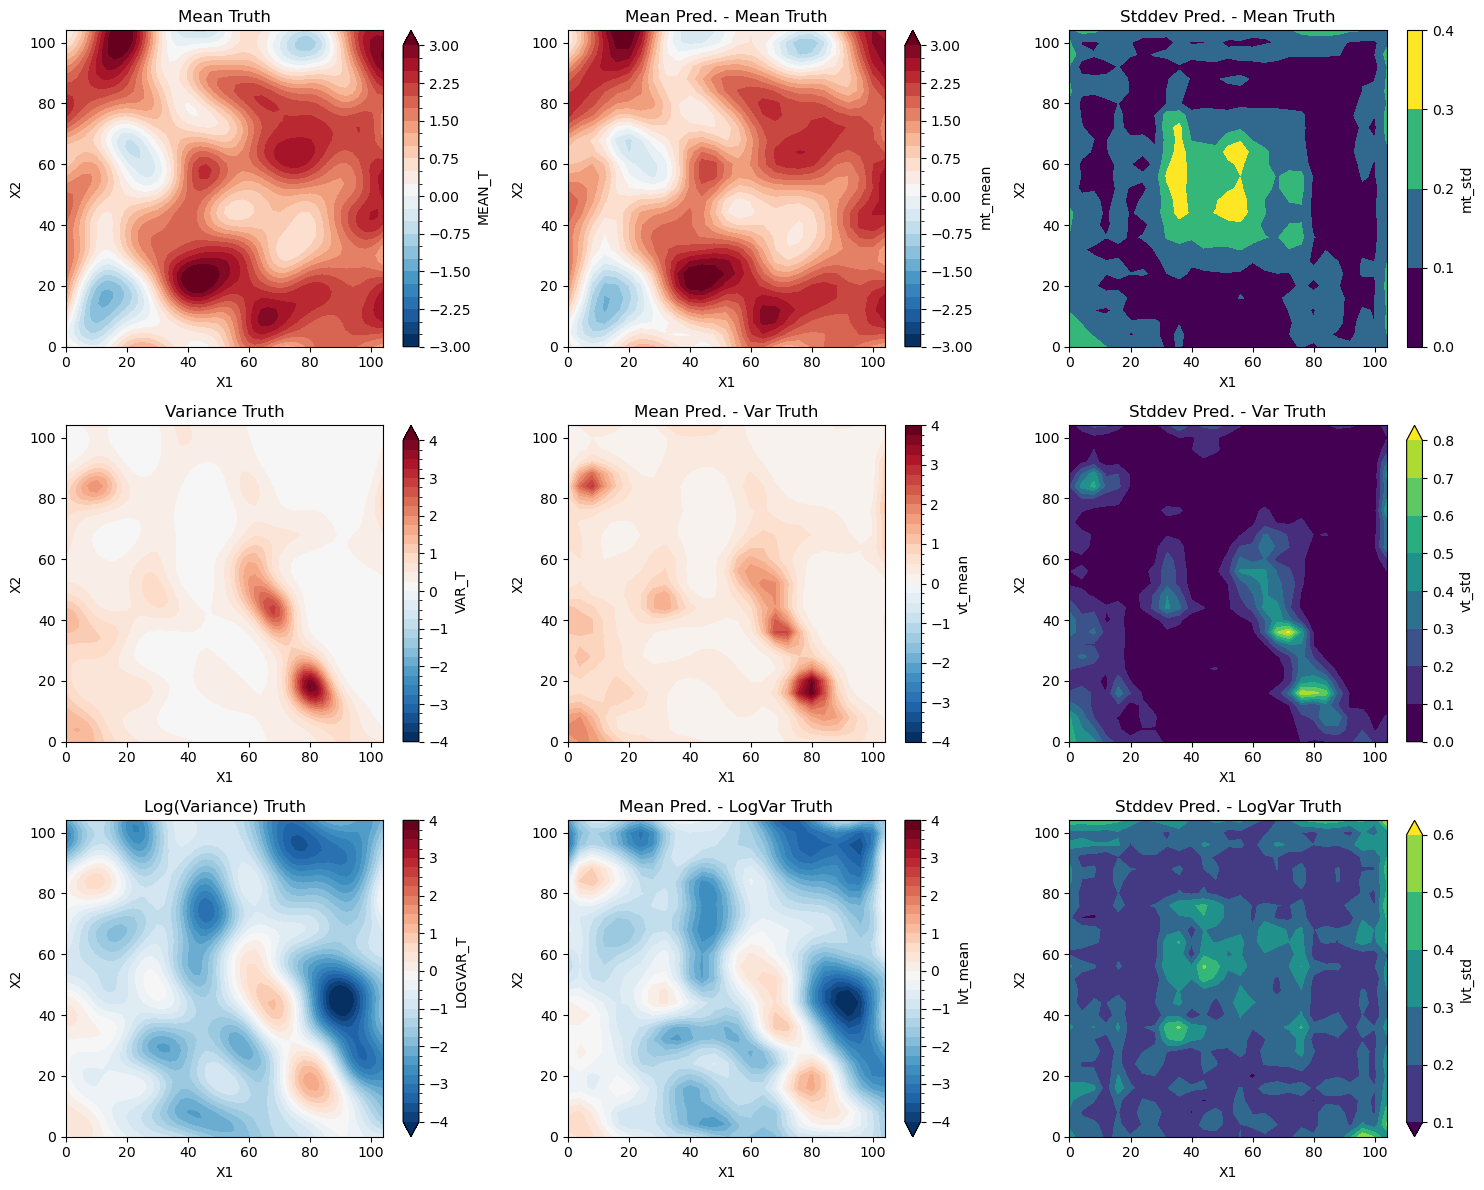

In [13]:
fig, axs = plt.subplots(3, 3, figsize=(15, 12))
plots = []
variables = ['MEAN_T','VAR_T','LOGVAR_T']
titles = ['Mean Truth','Variance Truth','Log(Variance) Truth']
pred_variables = ['mt_mean','mt_std','vt_mean','vt_std','lvt_mean','lvt_std']
pred_titles = ['Mean Pred. - Mean Truth','Stddev Pred. - Mean Truth','Mean Pred. - Var Truth','Stddev Pred. - Var Truth','Mean Pred. - LogVar Truth','Stddev Pred. - LogVar Truth']

mt_levels = create_levels(ds[['MEAN_T']],0.25,0,center=True)
vt_levels = create_levels(ds[['VAR_T']],0.25,0,center=True)
lvt_truth_levels = create_levels(ds[['LOGVAR_T']],0.25,0,center=True)
uncertainty_mt_levels = create_levels(ds_predictions[['mt_std']],0.1,1)
uncertainty_vt_levels = create_levels(ds_predictions[['vt_std']],0.1,1)
uncertainty_lvt_levels = create_levels(ds_predictions[['lvt_std']],0.1,1)

mean_levels = [mt_levels,vt_levels,lvt_truth_levels]
uncertainty_levels = [uncertainty_mt_levels,uncertainty_vt_levels,uncertainty_lvt_levels]

for i,var,title,level in zip([1,4,7], variables, titles,mean_levels):
    plt.subplot(3, 3, i)
    plots.append(ds[var].plot.contourf(x='X1',y='X2',levels=level))#,ax=axs.flatten()[0]))
    plt.title(title)

for i,j,level in zip([2,5,8], [0,2,4] ,mean_levels):
    plt.subplot(3, 3, i)
    var = pred_variables[j]
    title = pred_titles[j]
    plots.append(
        ds_predictions[f'{var}'].plot.contourf(x='X1',y='X2',levels=level)
    )
    plt.title(title)

for i,j,level in zip([3,6,9], [1,3,5], uncertainty_levels):
    plt.subplot(3, 3, i)
    var = pred_variables[j]
    title = pred_titles[j]
    plots.append(
        ds_predictions[f'{var}'].plot.contourf(x='X1',y='X2',levels=level)
    )
    plt.title(title)

plt.tight_layout()

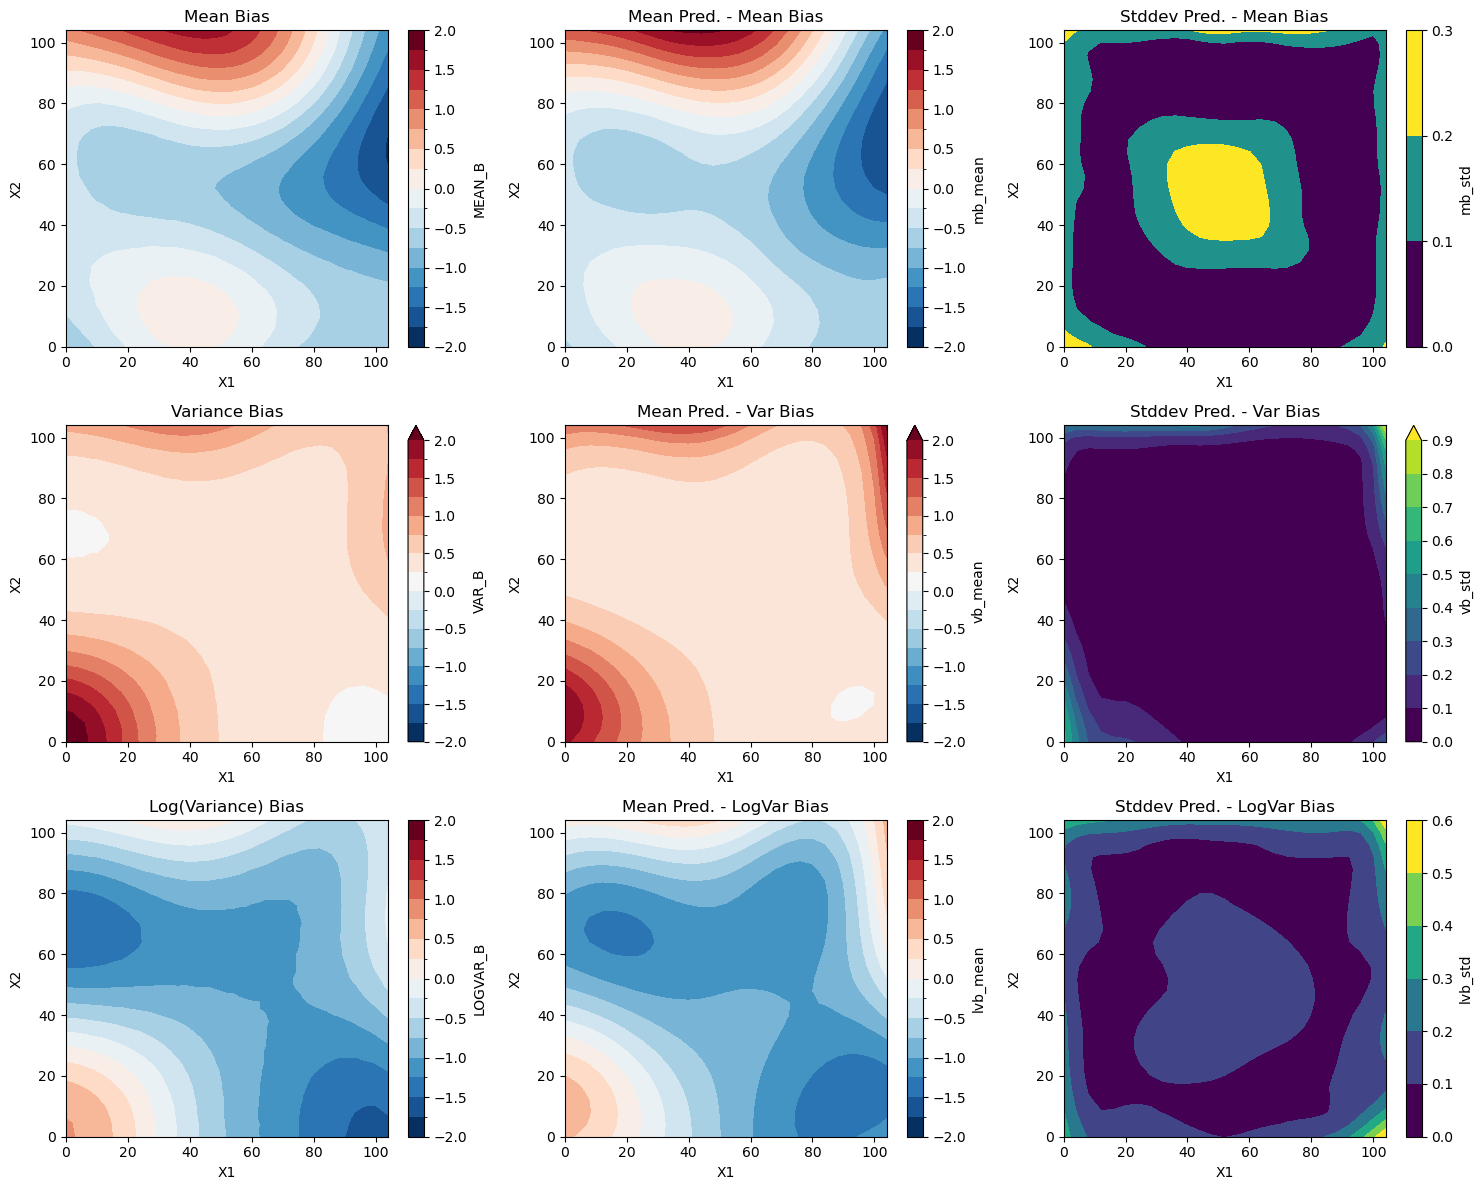

In [14]:
fig, axs = plt.subplots(3, 3, figsize=(15, 12))
plots = []
variables = ['MEAN_B','VAR_B','LOGVAR_B']
titles = ['Mean Bias','Variance Bias','Log(Variance) Bias']
pred_variables = ['mb_mean','mb_std','vb_mean','vb_std','lvb_mean','lvb_std']
pred_titles = ['Mean Pred. - Mean Bias','Stddev Pred. - Mean Bias','Mean Pred. - Var Bias','Stddev Pred. - Var Bias','Mean Pred. - LogVar Bias','Stddev Pred. - LogVar Bias']

mb_levels = create_levels(ds[['MEAN_B']],0.25,0,center=True)
vb_levels = create_levels(ds[['VAR_B']],0.25,0,center=True)
lvb_truth_levels = create_levels(ds[['LOGVAR_B']],0.25,0,center=True)
uncertainty_mb_levels = create_levels(ds_predictions[['mb_std']],0.1,1)
uncertainty_vb_levels = create_levels(ds_predictions[['vb_std']],0.1,1)
uncertainty_lvb_levels = create_levels(ds_predictions[['lvb_std']],0.1,1)

mean_levels = [mb_levels,vb_levels,lvb_truth_levels]
uncertainty_levels = [uncertainty_mb_levels,uncertainty_vb_levels,uncertainty_lvb_levels]

for i,var,title,level in zip([1,4,7], variables, titles,mean_levels):
    plt.subplot(3, 3, i)
    plots.append(ds[var].plot.contourf(x='X1',y='X2',levels=level))#,ax=axs.flatten()[0]))
    plt.title(title)

for i,j,level in zip([2,5,8], [0,2,4] ,mean_levels):
    plt.subplot(3, 3, i)
    var = pred_variables[j]
    title = pred_titles[j]
    plots.append(
        ds_predictions[f'{var}'].plot.contourf(x='X1',y='X2',levels=level)
    )
    plt.title(title)

for i,j,level in zip([3,6,9], [1,3,5], uncertainty_levels):
    plt.subplot(3, 3, i)
    var = pred_variables[j]
    title = pred_titles[j]
    plots.append(
        ds_predictions[f'{var}'].plot.contourf(x='X1',y='X2',levels=level)
    )
    plt.title(title)

plt.tight_layout()

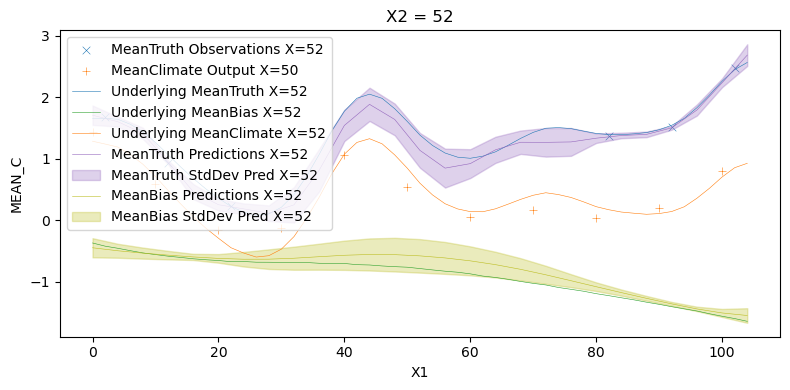

In [15]:
val = 52
cdc = 'tab:orange' #climate_data_colour
odc = 'tab:blue' #observation_data_colour
bdc = 'tab:green'#bias_data_colour
tpdc = 'tab:purple'#truth_prediction_data_colour
bpdc = 'tab:olive'#bias_prediction_data_colour

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

da_obs_slice=da_obs.sel(X2=val)
da_climate_slice=da_climate.sel(X2=val,method="nearest")
ax.scatter(da_obs_slice.X1, da_obs_slice.mean('D').data, s=30, marker='x',c=odc,label = f'MeanTruth Observations X={da_obs_slice.X2.data}')
ax.scatter(da_climate_slice.X1, da_climate_slice.mean('D').data, s=30, marker='+',c=cdc,label = f'MeanClimate Output X={da_climate_slice.X2.data}')

ds_slice = ds.sel(X2=val)
ds_slice['MEAN_T'].plot(label = f'Underlying MeanTruth X={val}',c=odc)
ds_slice['MEAN_B'].plot(label = f'Underlying MeanBias X={val}',c=bdc)
ds_slice['MEAN_C'].plot(label = f'Underlying MeanClimate X={val}',c=cdc)

ds_predictions_slice = ds_predictions.sel(X2=val)
mean_truth_mean_pred = ds_predictions_slice['mt_mean'].data
mean_truth_std_pred = ds_predictions_slice['mt_std'].data
mean_bias_mean_pred = ds_predictions_slice['mb_mean'].data
mean_bias_std_pred = ds_predictions_slice['mb_std'].data

ax.plot(ds_predictions_slice.X1, mean_truth_mean_pred, c=tpdc,label = f'MeanTruth Predictions X={val}')
ax.fill_between(ds_predictions_slice.X1,mean_truth_mean_pred+mean_truth_std_pred,mean_truth_mean_pred-mean_truth_std_pred,label=f'MeanTruth StdDev Pred X={val}',color=tpdc,alpha=0.3)
ax.plot(ds_predictions_slice.X1, mean_bias_mean_pred, c=bpdc,label = f'MeanBias Predictions X={val}')
ax.fill_between(ds_predictions_slice.X1,mean_bias_mean_pred+mean_bias_std_pred,mean_bias_mean_pred-mean_bias_std_pred,label=f'MeanBias StdDev Pred X={val}',color=bpdc,alpha=0.3)

plt.legend()
plt.tight_layout()

/home/jez/anaconda3/envs/BC/lib/python3.9/site-packages/xarray/core/nputils.py:157: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


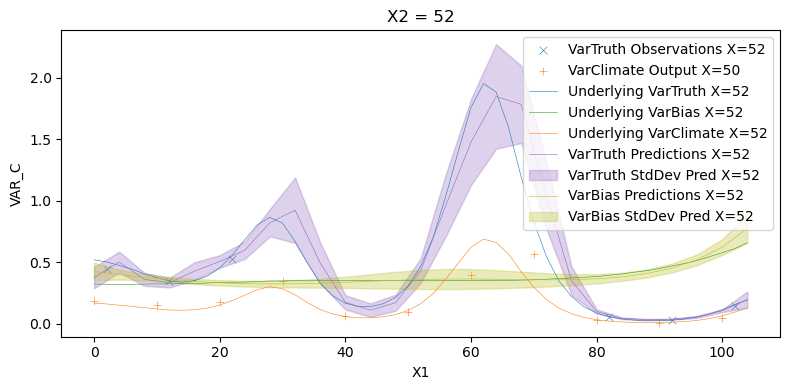

In [16]:
val = 52
cdc = 'tab:orange' #climate_data_colour
odc = 'tab:blue' #observation_data_colour
bdc = 'tab:green'#bias_data_colour
tpdc = 'tab:purple'#truth_prediction_data_colour
bpdc = 'tab:olive'#bias_prediction_data_colour

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

da_obs_slice=da_obs.sel(X2=val)
da_climate_slice=da_climate.sel(X2=val,method="nearest")
ax.scatter(da_obs_slice.X1, da_obs_slice.var('D').data, s=30, marker='x',c=odc,label = f'VarTruth Observations X={da_obs_slice.X2.data}')
ax.scatter(da_climate_slice.X1, da_climate_slice.var('D').data, s=30, marker='+',c=cdc,label = f'VarClimate Output X={da_climate_slice.X2.data}')

ds_slice = ds.sel(X2=val)
ds_slice['VAR_T'].plot(label = f'Underlying VarTruth X={val}',c=odc)
ds_slice['VAR_B'].plot(label = f'Underlying VarBias X={val}',c=bdc)
ds_slice['VAR_C'].plot(label = f'Underlying VarClimate X={val}',c=cdc)

ds_predictions_slice = ds_predictions.sel(X2=val)
vartruth_mean_pred = ds_predictions_slice['vt_mean'].data
vartruth_std_pred = ds_predictions_slice['vt_std'].data
varbias_mean_pred = ds_predictions_slice['vb_mean'].data
varbias_std_pred = ds_predictions_slice['vb_std'].data

ax.plot(ds_predictions_slice.X1, vartruth_mean_pred, c=tpdc,label = f'VarTruth Predictions X={val}')
ax.fill_between(ds_predictions_slice.X1,vartruth_mean_pred+vartruth_std_pred,vartruth_mean_pred-vartruth_std_pred,label=f'VarTruth StdDev Pred X={val}',color=tpdc,alpha=0.3)
ax.plot(ds_predictions_slice.X1, varbias_mean_pred, c=bpdc,label = f'VarBias Predictions X={val}')
ax.fill_between(ds_predictions_slice.X1,varbias_mean_pred+varbias_std_pred,varbias_mean_pred-varbias_std_pred,label=f'VarBias StdDev Pred X={val}',color=bpdc,alpha=0.3)

plt.legend()
plt.tight_layout()

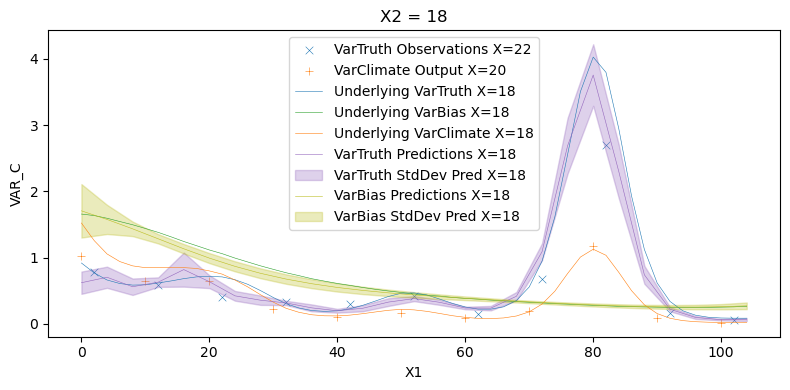

In [17]:
val = 18
cdc = 'tab:orange' #climate_data_colour
odc = 'tab:blue' #observation_data_colour
bdc = 'tab:green'#bias_data_colour
tpdc = 'tab:purple'#truth_prediction_data_colour
bpdc = 'tab:olive'#bias_prediction_data_colour

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

da_obs_slice=da_obs.sel(X2=val,method="nearest")
da_climate_slice=da_climate.sel(X2=val,method="nearest")
ax.scatter(da_obs_slice.X1, da_obs_slice.var('D').data, s=30, marker='x',c=odc,label = f'VarTruth Observations X={da_obs_slice.X2.data}')
ax.scatter(da_climate_slice.X1, da_climate_slice.var('D').data, s=30, marker='+',c=cdc,label = f'VarClimate Output X={da_climate_slice.X2.data}')

ds_slice = ds.sel(X2=val,method="nearest")
ds_slice['VAR_T'].plot(label = f'Underlying VarTruth X={val}',c=odc)
ds_slice['VAR_B'].plot(label = f'Underlying VarBias X={val}',c=bdc)
ds_slice['VAR_C'].plot(label = f'Underlying VarClimate X={val}',c=cdc)

ds_predictions_slice = ds_predictions.sel(X2=val,method="nearest")
vartruth_mean_pred = ds_predictions_slice['vt_mean'].data
vartruth_std_pred = ds_predictions_slice['vt_std'].data
varbias_mean_pred = ds_predictions_slice['vb_mean'].data
varbias_std_pred = ds_predictions_slice['vb_std'].data

ax.plot(ds_predictions_slice.X1, vartruth_mean_pred, c=tpdc,label = f'VarTruth Predictions X={val}')
ax.fill_between(ds_predictions_slice.X1,vartruth_mean_pred+vartruth_std_pred,vartruth_mean_pred-vartruth_std_pred,label=f'VarTruth StdDev Pred X={val}',color=tpdc,alpha=0.3)
ax.plot(ds_predictions_slice.X1, varbias_mean_pred, c=bpdc,label = f'VarBias Predictions X={val}')
ax.fill_between(ds_predictions_slice.X1,varbias_mean_pred+varbias_std_pred,varbias_mean_pred-varbias_std_pred,label=f'VarBias StdDev Pred X={val}',color=bpdc,alpha=0.3)

plt.legend()
plt.tight_layout()